### Project Outline

* Read data and create subset for ones that don't have VIAF ID. 
    * We might work with the entire dataset though, because more data might make clustering names easier.
* Create 3 new columns: `parsedName`, `_personID`, `regularizedName`
    * The leading underscore indicates `personId` is a temporary column. The ID can just be a sequential integer as long as it's unique - it doesn't need to be a true hash.
    * Whether we can reliably create a `regularizedName` - i.e. a modern regular version that should replace all variations in the metadata remains to be seen. It might not be possible without a lot of human intervention. 
* We need the following functions:
    * `name_preprocess()`: Returns a cleaned up version of the name string or `None` if it doesn't look like a name.
    * `substitution_cost()`: Needed for `weighted_levenshteain()`
    * `substitution_cost_dict_generate()`: generate a cost dict for `weighted_levenshtein()`
    * `weighted_levenshtein()`
    * `name_pair()`: take a pair of preprocessed names and return a `true` if they are a close enough match that we should compute `weighted_levenshtein()` or `false` if we should ignore them. 
    * `ner_pubStmt()`: Takes the `pubStmt()` field and runs NER with `Spacy` on it.
* Procedure:
    * For each row, run `name_preprocess()`. 
        * If we get a name back, we store it in `parsedName`
    * After we are done with the entire DataFrame, take the subset that has `parsedName` set.
        * The other rows get written out to a CSV (without the 3 new columns -- these need to be run through NER and/or checked by hand)
    * In the new subset DataFrame, we generate combinations of pd.Dataframe `index` ids to generate all possible name pairs. Then run them through `name_pair()`.
    * If they pass, we run them through `weighted_levenshtein()` and store the result in a `networkx` graph where the nodes are pd.Dataframe `id` and the edges are 1/weigthed_levenshtein() \[i.e. the more similar the nodes, the higher the weight\]. If the `weighted_levenshtein()` score is above a certain threshold, we don't add it to the graph. 
    * When we are done, we break down the graph into discrete subgraphs using [this approach](https://stackoverflow.com/questions/61536745/how-to-separate-an-unconnected-networkx-graph-into-multiple-mutually-disjoint-gr). Each subgraph will be one name in all its variant forms. This performs the clustering for us. 
    * We sort these graphs by number of nodes and assign each of them a unique ID starting at 1 and then write everythin out to a CSV.

In [1]:
%load_ext line_profiler

# Set up all imports and logging
import itertools, json, logging, re, string, sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from strsimpy.weighted_levenshtein import WeightedLevenshtein

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

sh = logging.StreamHandler(sys.stderr)
sh.setLevel(logging.INFO)
fmt = '%(asctime)s %(message)s'
dfmt = '%y-%m-%d  %H:%M:%S'
logging.basicConfig(handlers=(sh,), format=fmt, datefmt=dfmt, level=logging.INFO)

##### All adjustable parameters are set here

In [82]:
printers_data_file = 'data/printers_etc.csv'
name_abbreviations_file ='./data/name_abbreviations.json'

# We'll output bad data to these files
printers_data_file_date_notparsed_doubleyears = 'data/printers_etc_date_notparsed_doubleyears.csv'
printers_data_file_date_notparsed = 'data/printers_etc_date_notparsed.csv'
printers_data_file_pubstmt_notparsed = 'data/printers_etc_pubstmt_notparsed.csv'

n_test = 0    # Subset of data for tests. Set to 0 or more than the total datasize to use everything.
records_with_viaf = False    # Whether we eliminate items that already have a resolved VIAF ID

# Change these values to zoom in on shorter yearspans in the visualization
start_year = 1400
end_year = 1700
records_within_datespan = True # If this is set, only the above datespan is kept

# This needs to have both (c1, c2) and (c2, c1) pairs only if the weights are different. 
# Otherwise (c2, c1) etc is generated automatically below.
substitution_cost_dict = {('i', 'j'): 0.3,
                          ('u', 'v'): 0.3,
                          ('y', 'i'): 0.3,
                          ('e', 'y'):.7}

##### Read external files and visualize raw data

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Total Number of texts:  78,112
Texts with VIAF IDs:    15,927
Texts without VIAF IDs: 62,185
Texts with bad dates (ignored):2,041


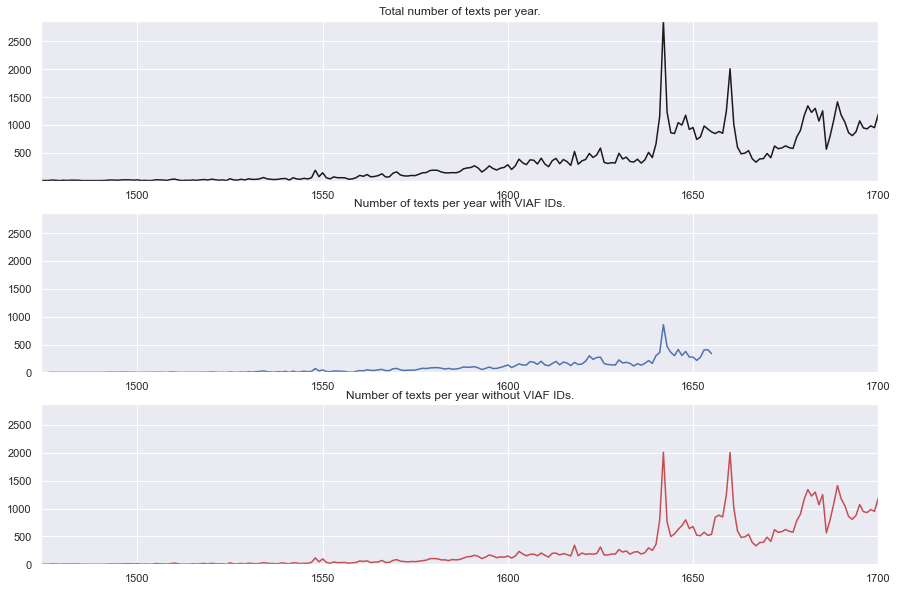

In [91]:
# The name abbreviations dictionary can be passed to the name_preprocess function
with open(name_abbreviations_file) as file:
    name_abbreviations = json.load(file)

printers_df = pd.read_csv(printers_data_file)

# Convert to numeric but leave strings and nans untouched
# Extract dates with two years - eg. 1660 1662
printers_df['parsedDate'] = printers_df['parsedDate'].apply(pd.to_numeric, errors='ignore')
printers_df_strings = printers_df[printers_df['parsedDate'].apply(lambda x: isinstance(x, str))]
printers_df_strings.to_csv(printers_data_file_date_notparsed_doubleyears)

# Extract all rows with badly parsed dates (including above rows)
printers_df['parsedDate'] = printers_df['parsedDate'].apply(pd.to_numeric, errors='coerce')
filter_baddates = printers_df['parsedDate'].isna()
printers_df_baddates = printers_df[filter_baddates]
printers_df_baddates.to_csv(printers_data_file_date_notparsed)

# Retain rows with well formed dates
printers_df = printers_df[~filter_baddates]

viaf_exists = printers_df[~printers_df['viafId'].isna()]
viaf_needed = printers_df[printers_df['viafId'].isna()]

total_counts = printers_df.groupby(['parsedDate'])['parsedDate'].count()
viaf_exists_counts = viaf_exists.groupby(['parsedDate'])['parsedDate'].count()
viaf_needed_counts = viaf_needed.groupby(['parsedDate'])['parsedDate'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if int(total_counts.index[0]) < start_year else int(total_counts.index[0])
end_year = end_year if int(total_counts.index[-1]) > end_year else int(total_counts.index[-1])

axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts[start_year:end_year].values+1)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts[start_year:end_year].values)+1), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts[start_year:end_year].values)+1), xlabel=None, title='Number of texts per year without VIAF IDs.')
print('Total Number of texts:     {:,}\nTexts with VIAF IDs:    {:,}\nTexts without VIAF IDs: {:,}\nTexts with bad dates (ignored):{:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed), len(printers_df_baddates)))

In [63]:
numeric_dates.isna()

0        False
1        False
2        False
3        False
4        False
         ...  
80148     True
80149     True
80150     True
80151     True
80152     True
Name: parsedDate, Length: 80153, dtype: bool

In [48]:
# slice data to produce the final dataframe we'll work on
if records_with_viaf:
    df = printers_df
    logging.info('Including records with assigned VIAF IDs')
else:
    df = viaf_needed
    logging.info('Excluding records with assigned VIAF IDs')

if records_within_datespan:
    df = df[(df['parsedDate']>=start_year) & (df['parsedDate']<=end_year)]
    logging.info(f'Keeping records within {start_year} and {end_year}')
    
if n_test==0:
    df = df
    logging.info(f'Keeping all {len(df)} records')
else:
    df = df[:n_test]
    logging.info(f'Keeping the first {len(df)} records')

23-03-02  00:29:21 Excluding records with assigned VIAF IDs
23-03-02  00:29:21 Keeping records within 1474 and 1818
23-03-02  00:29:21 Keeping all 62210 records


In [49]:
# Functions

def name_preprocess(full_name, lower_case=False, title_case=True, \
                    name_abbreviations=name_abbreviations, \
                    max_length=30, min_tokens=2, max_tokens=4):
    """
    Returns a cleaned up version of the name string or None if it doesn't look like a name.
    
    We remove any preceding 'me', clean up punctuation, extra spaces. Throw out 
    names that are too long or have too few or too many tokens. Substitute vv -> w.
    Also expand name abbreviations. Lower and Title case options available. Titlecase
    takes precedence.
    """
    full_name = re.sub(f'^me\s*|[{string.punctuation}]|\d*', '', full_name)
    # Collapse vv to w
    full_name = re.sub('vv', 'w', full_name)
    full_name = re.sub('VV', 'W', full_name)

    #ignore names that are too long
    if len(full_name) > max_length:
        logging.info(f'Too long: Ignoring: {full_name}')
        return None
    #find all strings separated by whitespace
    words = re.findall(r'\b\w+\b', full_name)
    # check if the number of words is at least 2 or over 4
    if len(words) < min_tokens:
        logging.info(f'Too few tokens: Ignoring: {full_name}')
        return None
    if len(words) > max_tokens:
        logging.info(f'Too many tokens: Ignoring: {full_name}')
        return None
    # return the first word and remaining string as a tuple
    first_name = words[0]
    if first_name in name_abbreviations:
        first_name = name_abbreviations[first_name]
    last_name = ' '.join(words[1:])
    
    if lower_case:
        first_name = first_name.lower()
        last_name = last_name.lower()
    
    if title_case:
        first_name = first_name.title()
        last_name = last_name.title()

    return (first_name, last_name)

def substitution_cost_dict_generate(substitution_cost_dict, swapcase_weight=0.2):
    """
    Generate reverse pairs for the cost dictionary. I.e. is ('u', 'v') is supplied,
    generate ('v', 'u'). ('u', 'V') and ('U', 'v') are also generated. Other letters 
    get the swapcase weight. So the cost of 'A'->'a' is swapcase_weight. This can be 
    set to zero, if you don't care about swapping cases.
    """
    reversed_substitution_cost_dict = {}

    for (c1, c2), w in substitution_cost_dict.items():
        # (i, j) -> (j, i)
        if (c2, c1) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c2, c1)] = w
        # (i, j) -> (i, J) and (I, j)
        if (c1.swapcase(), c2) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1.swapcase(), c2)] = w
        if (c1, c2.swapcase()) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1, c2.swapcase())] = w
        # (a, A), (A, a) etc
        for l in string.ascii_letters:
            if (l, l.swapcase()) not in substitution_cost_dict:
                reversed_substitution_cost_dict[(l, l.swapcase())] = swapcase_weight

    substitution_cost_dict = {**substitution_cost_dict, **reversed_substitution_cost_dict}

    return substitution_cost_dict

# We'll call the above function to expand our cost dictionary
substitution_cost_dict = substitution_cost_dict_generate(substitution_cost_dict)

def substitution_cost(x, y, substitution_cost_dict=substitution_cost_dict):
    """
    Takes a pair of letters and returns a substitution cost for them
    """
    sc = substitution_cost_dict[(x,y)] if (x, y) in substitution_cost_dict else 1.0
    return sc

# Initialize the WL function with custom weights
weighted_levenshtein = WeightedLevenshtein(substitution_cost_fn=substitution_cost)

def name_pair(n1, n2, letter_similarity_threshold=.5):
    """
    This is a prescreening function to judge if a pair of names is viable for a match
    with weighted levenshtein. We can set up various criteria for a possible match.
    
    If names have same or similar initials. 
    Not implemented yet: If they share a substantial portion of their letters.
    """
    f1, l1 = n1
    f2, l2 = n2
    
    # Do they have same or similar initials
    if (((f1[0]==f2[0]) or (substitution_cost(f1[0], f2[0])<letter_similarity_threshold)) and \
                      ((l1[0]==l2[0]) or (substitution_cost(l1[0], l2[0])<letter_similarity_threshold))):
        return True
    return False

def name_pair_combinations(df):
    """
    Returns vialble name pairs as a list of indices. Note that each name will show
    up at least once as it is similar to itself. So unique names are accounted for.
    """
    filter = []
    for i, ni1 in enumerate(df.itertuples()):
        if i%1000 == 0:
            logging.info(f'Name pairs parsed: {i}')
        for ni2 in df[i:].itertuples():
            name1 = ni1.namePreprocessed
            name2 = ni2.namePreprocessed
            index1 = ni1.Index
            index2 = ni2.Index
            if name_pair(name1, name2):
                filter.append((index1, index2))
    return filter

def weighted_levenshtein_compute(n1, n2, weighted_levenshtein=weighted_levenshtein.distance, initial_match_weight=.2):
    f1, l1 = n1
    f2, l2 = n2

    if (f1 == f2) and (l1 == l2):
        d1 = 0
        d2 = 0
    elif (len(f1) == 1 or len(f2) == 1) and (f1[0] == f2[0]):
        d1 = initial_match_weight
        d2 = weighted_levenshtein(l1, l2)
    else:
        d1 = weighted_levenshtein(f1, f2)
        d2 = weighted_levenshtein(l1, l2)
    return (d1+d2)
    


In [ ]:
# Preprocess all names and create new column for it
df['namePreprocessed'] = df['name'].map(name_preprocess)
# Separate rows that don't look like names. We'll clean these later
df_unresolved_name = df[df['namePreprocessed'].isnull()]
df = df[~df['namePreprocessed'].isnull()]

In [ ]:
# Create list of indices of all viable name_pairs 
index_pairs = name_pair_combinations(df)

In [ ]:
for i, (i1, i2) in enumerate(index_pairs):
    if i1 == i2:
        d = 0
    else:
        n1 = df.loc[i1].namePreprocessed
        n2 = df.loc[i2].namePreprocessed    
        d = weighted_levenshtein_compute(n1, n2)  
    if d < 2.0:
        print(i1, i2, d)
    if i%1000 == 0:
        logging.info(f'At index {i}')

In [ ]:
df = pd.DataFrame({'Year': [1900, 1902, 1903], 'Name': ['Tom', 'Dick', 'Harry']})
print(df)

In [72]:
printers_df = pd.read_csv(printers_data_file)
printers_df['parsedDate'] = printers_df['parsedDate'].apply(pd.to_numeric, errors='ignore')
printers_df[printers_df['parsedDate'].apply(lambda x: isinstance(x, str))]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId
40273,A58336,ed.,editor,"Muggleton, Lodowick, 1609 1698,",estc_ep,"A divine looking-glass, or, The third and last...","Reeve, John, 1608-1658.",1656 1661,Printed in the year of Our Lord 1656 and since...,NaN,"s.n.], [London? : Printed in the year of Our L...",NaN,NaN
43250,A36701,printer,printer,William Wilson,tcp_ep,Three poems upon the death of the late usurper...,"Dryden, John, 1631-1700.",1659 1682,1659 : 1682.,NaN,"Printed by William Wilson, 1659 : And reprinte...",NaN,NaN
51412,A51287,printer,printer,I. R.,tcp_ep,An appendix to the late antidote against idola...,"More, Henry, 1614-1687.",1672 1673,"MDCLXXII, 1673.",the Sign of the Bishops-Head in St. Pauls Chur...,"printed by I. R. for Walter Kettilby, at the S...",NaN,NaN
51413,A51287,publisher,publisher,Walter Kettilby,tcp_ep,An appendix to the late antidote against idola...,"More, Henry, 1614-1687.",1672 1673,"MDCLXXII, 1673.",the Sign of the Bishops-Head in St. Pauls Chur...,"printed by I. R. for Walter Kettilby, at the S...",NaN,NaN
56048,B02107,printer,printer,the heir of Andrew Anderson,tcp_ep,By the King. A proclamation containing His Maj...,Scotland. Sovereign (1660-1685 : Charles II),1679 1679,1679 ; 1679.,NaN,"printed by the heir of Andrew Anderson ..., fo...",NaN,NaN
58552,A58724,patron,patron,His Most Sacred Majesty,tcp_ep,A proclamation concerning the students in the ...,England and Wales. Sovereign (1660-1685 : Char...,1681 1682,"1681. ; January 29th, following [1682]",NaN,"Printed by the heir of Andrew Anderson, printe...",NaN,NaN
58553,A58724,printer,printer,the heir of Andrew Anderson,tcp_ep,A proclamation concerning the students in the ...,England and Wales. Sovereign (1660-1685 : Char...,1681 1682,"1681. ; January 29th, following [1682]",NaN,"Printed by the heir of Andrew Anderson, printe...",NaN,NaN
62142,B03087,assigns,assigns,"John Bill deceas'd, and",tcp_ep,Whereas it hath pleased almighty God to call t...,England and Wales. Parliament. House of Lords.,1684 1685,1684 ; anno Dom. 1685.,NaN,"Printed by the assigns of John Bill deceas'd, ...",NaN,NaN
62143,B03087,printer,printer,Henry Hills,tcp_ep,Whereas it hath pleased almighty God to call t...,England and Wales. Parliament. House of Lords.,1684 1685,1684 ; anno Dom. 1685.,NaN,"Printed by the assigns of John Bill deceas'd, ...",NaN,NaN
62144,B03087,printer,printer,Thomas Newcomb,tcp_ep,Whereas it hath pleased almighty God to call t...,England and Wales. Parliament. House of Lords.,1684 1685,1684 ; anno Dom. 1685.,NaN,"Printed by the assigns of John Bill deceas'd, ...",NaN,NaN


In [55]:
#pd.to_numeric(tdf['parsedDate'], errors='coerce')
#pd.to_numeric(tdf['parsedDate'].astype(str).str[:4])
tdf[tdf['parsedDate'].apply(lambda x: isinstance(x, str))]

,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId
78131,B03369,printer,printer,J. Benson,tcp_ep,"The fox unkennel'd; or, The Whiggs idol. By a ...",NaN,1750 1755,[1715],the Strand,"Printed by J. Benson in the Strand, London, : ...",NaN,NaN
